In [10]:
import numpy as np
import math
# import astropy.units as u
from matplotlib import pyplot as plt
import time
from numba import njit,prange
# import scipy.interpolate as interpl
# from numba.extending import overload
# from mpl_toolkits.mplot3d import axes3d
# from matplotlib import cm
# from matplotlib import pyplot as plt


In [3]:
@njit(boundscheck=True)
def FDM_BIv03(VRF,VDC):
    # Initialize trap parameters
    
    #for the main RF ring:
    RF_R = .015; #max radius in units m
    RF_r = .0024; #min radius in units m
    rcone=.00519; #radius where inner cut begins
    slope=np.tan(79*np.pi/180)**(-1);
    const=slope-rcone
    H=.001; #height of electrode above z axis at the start of the cut
    c3=H-slope*rcone

    #for the voltage bias plates

    h = .000551; #displacement of cone ends from center
    R2=.00111/2;#radius of big cone at displacement h
    R1=.00108/2;#radius of little cone at displacement h from center
    h1=.00295;#total height of exposed cone from tip to the flat plate section 
    c1=h-np.sqrt(3)*R1;#small cone axial offset from center
    c2=h-R2; # big cone axial offset from center

    # Grid properties
    gmax = .005 #max and min grid point position
    #number of gridpoints in position space
    points=401
    #####number of steps (i.e. 99 steps=100 grid poingts)
    steps = points-1
    ####initialize spatial coords
    x = np.linspace(-gmax,gmax,points) #m, sets boundaries of solution space
    y = np.linspace(-gmax,gmax,points) #m, sets boundaries of solution space
    z = np.linspace(-gmax,gmax,points) #m, sets boundaries of solution space
    #####record middle positions
    size=len(x)
    xmid = int((size)/2)
    ymid = int((size)/2)
    zmid = int((size)/2)
    #####initialize the lattice points, that is the points that will be
    #####updated in the simulation
    lattice_points=np.zeros((size**3,3))
    marker=0
    
    V0 = np.zeros((size,size,size)) #initialize the matrix for electric potential
    V0dc= np.zeros((size,size,size))
    V0_temp=np.zeros((size,size,size))
    V0dc_temp=np.zeros((size,size,size))
    cords=np.zeros((size,size,size,3))
    its = 600 #number of iterations
    CenterV = np.zeros((its,1)) #keep track of the potential value at the center at each iteration

    ## Define the boundary conditions
    # print('Initializing boundaries...')

    for i in range(len(x)):
        for j in range(len(y)):
            
            for k in range(len(z)):
                cords[i,j,k]=[i,j,k]
                #first the RF top electrode: h+h1<z[k]<h+h1+.001, 
                if ((z[k] > h) and (z[k]<(h+h1)) and (z[k] > np.sqrt(x[i]**2 + y[j]**2)+c2) and (z[k] < (np.sqrt(3)*np.sqrt(x[i]**2 + y[j]**2)+c1))):

                   # disp(['hi'])
                    V0[i,j,k] = VRF[9]
                    V0dc[i,j,k]=VDC[9]

                elif((z[k]>h+h1) and (z[k]<(h+h1+.001)) and (z[k]<(np.sqrt(3)*np.sqrt(x[i]**2 + y[j]**2)+c1))):     #and (abs(x[i])<.00675/2)
                    V0[i,j,k] = VRF[9]
                    V0dc[i,j,k]=VDC[9]
                    #then the voltage plates on the bottom:
                elif ((z[k] < -h) and (z[k]>-h-h1) and (z[k] < -(np.sqrt(x[i]**2 + y[j]**2)+c2)) and (z[k] > -(np.sqrt(3)*np.sqrt(x[i]**2 + y[j]**2)+c1))):
                    V0[i,j,k] = VRF[8]
                    V0dc[i,j,k]=VDC[8]

                elif((z[k]<-(h+h1)) and (z[k]>-(h+h1+.001)) and (z[k]>-(np.sqrt(3)*np.sqrt(x[i]**2 + y[j]**2)+c1) )):
                    V0[i,j,k] = VRF[8]
                    V0dc[i,j,k]=VDC[8]

                elif ((x[i]**2+y[j]**2>RF_r**2) and (z[k]<.001) and (z[k]>-.001) and (abs(z[k])< slope*(np.sqrt(x[i]**2+y[j]**2))+ c3)):
              # #  disp(['hi'])
                   try:
                     angle=abs(np.arctan(y[j]/x[i]))*180/np.pi#####calculate the angle in polar coordinates, convert to degrees
                     # print(angle)
                     if  ((x[i]>0) and (y[j]>0) and (12.5<angle) and (angle<32.5)):
                        # disp(['hi'])

                         V0[i,j,k] = VRF[0]
                         V0dc[i,j,k]=VDC[0]

                     elif ((x[i]>0) and (y[j]>0) and (57.5<angle) and (angle<77.5)):
                       #  disp(['hi'])
                         V0[i,j,k] = VRF[1]
                         V0dc[i,j,k]=VDC[1]

                     elif ((x[i]<0) and (y[j]>0) and (102.5<180-angle) and (180-angle<122.5)):
                         V0[i,j,k] = VRF[2]
                         V0dc[i,j,k]=VDC[2]
                     elif ((x[i]<0) and (y[j]>0) and (147.5<180-angle) and (180-angle<167.5)):
                         V0[i,j,k] = VRF[3]
                         V0dc[i,j,k]=VDC[3]
                     elif ((x[i]<0) and (y[j]<0) and (192.5<180+angle) and (180+angle<212.5)):
                         V0[i,j,k] = VRF[4]
                         V0dc[i,j,k]=VDC[4]
                     elif ((x[i]<0) and (y[j]<0) and (237.5<180+angle) and (180+angle<257.5)):
                         V0[i,j,k] = VRF[5]
                         V0dc[i,j,k]=VDC[5]

                     elif ((x[i]>0) and (y[j]<0) and (282.5<360-angle) and (360-angle<302.5)):
                         V0[i,j,k] = VRF[6]
                         V0dc[i,j,k]=VDC[6]
                        
                     elif (x[i]>0 and y[j]<0 and (327.5<360-angle) and (360-angle<347.5)):
                         V0[i,j,k] = VRF[7]
                         V0dc[i,j,k]=VDC[7]

                     else: ###else it is a point that must get updated
                        # disp(['hi'])
                         V0[i,j,k] = 0
                         V0dc[i,j,k]=0
                         lattice_points[marker]=[i,j,k]
                         marker+=1
              #       break
                   except: 
                         V0[i,j,k] = 0
                         V0dc[i,j,k]=0
                         lattice_points[marker]=[i,j,k]
                         marker+=1
                #then the voltage everywhere else
                #inside area w no trap electrodes
                elif ((x[i]**2+y[j]**2) < (RF_r)**2 and abs(z[k])<h):
                    #disp(['hi'])
                    lattice_points[marker]=[i,j,k]
                    marker+=1
                else:
                    lattice_points[marker]=[i,j,k]
                    marker+=1
    lattice_points=lattice_points[0:marker]

    V0_temp=V0    
    V0dc_temp=V0dc

    ## Define the initial potential using FDM first in big steps
    #disp(['Calculating V in big steps...'])

    
    for iterate in range(0,int(its/2)): 
         for I in range (marker):
             point=lattice_points[I]
             a=int(point[0])
             b=int(point[1])
             c=int(point[2])
             if ((a>3 and b>3 and c>3 and a<points-5 and b<points-5 and c<points-5)):
                 V0_temp[a,b,c] = 1/6*(V0[a+4,b,c]+V0[a-4,b,c]+V0[a,b+4,c]+V0[a,b-4,c]+V0[a,b,c+4]+V0[a,b,c-4])
                 V0dc_temp[a,b,c] = 1/6*(V0dc[a+4,b,c]+V0dc[a-4,b,c]+V0dc[a,b+4,c]+V0dc[a,b-4,c]+V0dc[a,b,c+4]+V0dc[a,b,c-4])
             
       
        
         CenterV[iterate] = V0[xmid,ymid,zmid]
         V0=V0_temp
         V0dc=V0dc_temp
          # iterate+=1
         # print(iterate)

    
    ## Define the initial potential using FDM in small steps
   # disp(['Calculating V in small steps...'])


    for iterate in range(int(its/2),int(3*its/4)):
         for I in range (marker):
             point=lattice_points[I]
             a=int(point[0])
             b=int(point[1])
             c=int(point[2])
             if ((a>1 and b>1 and c>1 and a<points-3 and b<points-3 and c<points-3)):
                 V0_temp[a,b,c] = 1/6*(V0[a+2,b,c]+V0[a-2,b,c]+V0[a,b+2,c]+V0[a,b-2,c]+V0[a,b,c+2]+V0[a,b,c-2])
                 V0dc_temp[a,b,c] = 1/6*(V0dc[a+2,b,c]+V0dc[a-2,b,c]+V0dc[a,b+2,c]+V0dc[a,b-2,c]+V0dc[a,b,c+2]+V0dc[a,b,c-2])
             
                    
                   
                   
       
         CenterV[iterate] = V0[xmid,ymid,zmid]
         V0=V0_temp
         V0dc=V0dc_temp
        
                
    
    
   # # disp(['Calculating V in baby steps...'])
    for iterate in range(int(3*its/4),its):
         for I in range (marker):
             point=lattice_points[I]
             a=int(point[0])
             b=int(point[1])
             c=int(point[2])
             if ((a>0 and b>0 and c>0 and a<points-2 and b<points-2 and c<points-2)):
                 V0_temp[a,b,c] = 1/6*(V0[a+1,b,c]+V0[a-1,b,c]+V0[a,b+1,c]+V0[a,b-1,c]+V0[a,b,c+1]+V0[a,b,c-1])
                 V0dc_temp[a,b,c] = 1/6*(V0dc[a+1,b,c]+V0dc[a-1,b,c]+V0dc[a,b+1,c]+V0dc[a,b-1,c]+V0dc[a,b,c+1]+V0dc[a,b,c-1])
             
                    
                   
                   
        
         CenterV[iterate] = V0[xmid,ymid,zmid]
         V0=V0_temp
         V0dc=V0dc_temp
    
####return the RF simulation results, DC results, Points to be updated, and array of all coordinates
    return V0,V0dc,CenterV,lattice_points,cords


In [5]:
    ###Sample voltages to use in the simulation
RF=np.array([1000,0,1000,0,1000,0,1000,0,1000,1000])
DC=np.array([10,0,0,0,-10,0,0,0,0,0])
####record the start time
start=time.time()
#Run the simulation
A=FDM_BIv03(RF,DC)
print("time elapsed = ",time.time()-start)


###save the data (optional )
# path="change_my_name"
# np.save(path)

time elapsed =  301.53671765327454


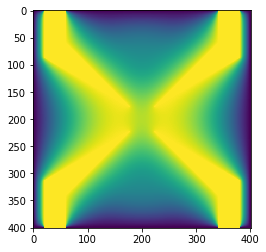

In [10]:
###################PLOTTING EXAMPLES###########
# plot the xy plane for the dc potential
plt.imshow(A[0][:,200,:])
#plot the z axis for the RF potential
#plt.plot(plt.imshow(A[0][50,50,:]))


In [6]:
####***grid size in metres, size is number of lattice points. V is a NxNxN grid of potential values Feturns NxNxN grid of Efield magnitudes
def Efield_solve(V,size,grid):
    
    Ex=np.zeros((size,size,size))
    Ey=np.zeros((size,size,size))
    Ez=np.zeros((size,size,size))
    Ex,Ey,Ez = np.gradient(V,grid/size)
    Emag=np.zeros((size,size,size))
    for a in range(0,size):
       for b in range(0,size):
          
          for c in range(0,size):
              Emag[a,b,c] = math.sqrt(Ex[a,b,c]**2+Ey[a,b,c]**2+Ez[a,b,c]**2)
    return Emag
###return pseudopotential in eV. E_field must be NxNxN
def Pseudo_solve(E_field,size,grid,omega,M,Q):
    PseudoeV=np.zeros((size,size,size))
    for a in range(0,size):
       for b in range(0,size):
          for c in range(0,size):
              PseudoeV[a,b,c] = Q**2/(4*M*omega**2)*E_field[a,b,c]**2
    return PseudoeV
###tahes dc potential and pseudo potential to give effective potential energy
def Eeff(PS,VDC,Q,size):
    PE=np.zeros((size,size,size),dtype=np.long)
    for a in range(0,size):
       for b in range(0,size):
          for c in range(0,size):
              PE[a,b,c]=Q*VDC[a,b,c]+PS[a,b,c]
    return PE
def Force_field(PE,grid,steps):
    return np.gradient(PE,grid/steps)              

In [19]:
RF1 = np.array([1, 1, 1])
####record the start time
start=time.time()
#Run the simulatio
B = Efield_solve([1,1,1],1, 400)
print("time elapsed = ",time.time()-start)

IndexError: invalid index to scalar variable.